In [ ]:
# default_exp benchmarking

In [ ]:
#export
from alphaquant.diff_analysis_manager import run_pipeline

In [ ]:
#export
import pandas as pd
def get_tps_fps(result_df, prot2org_file, thresh = 0.05, fc_thresh = 0.3):
    annotated = annotate_dataframe(result_df, prot2org_file)
    condpairs = result_df["condpair"].drop_duplicates()


    for condpair in condpairs:
        annotated_condpair = annotated[annotated["condpair"]==condpair]
        num_tps = sum(annotated_condpair["TP"])
        num_fps = sum(annotated_condpair["FP"])
        annotated_fcfilt = annotated_condpair[annotated["log2fc"] >fc_thresh]
        num_regulated_prots = sum(annotated_fcfilt["fdr"]<thresh)
        num_true_positives = sum(annotated_fcfilt["TP"] &(annotated_fcfilt["fdr"]<0.05))
        num_false_positives = sum(annotated_fcfilt["FP"] &(annotated_fcfilt["fdr"]<0.05))

        print(f'condpair {condpair}')
        print(f"total TPs {num_tps}")
        print(f"total FPs {num_fps}")
        print(f'regulated {num_regulated_prots}')
        print(f'false positives {num_false_positives}')
        print(f'true positives {num_true_positives}')
        print(f'regulated control {num_false_positives+num_true_positives}')
        print(f'precision {num_false_positives/num_regulated_prots}')
        print(f'precision {num_false_positives/num_regulated_prots}')


def annotate_dataframe(result_df, prot2org_file):
    prot2org = pd.read_csv(prot2org_file, sep = "\t")
    prot2org["FP"] = (prot2org["organism"] == "Homo sapiens")
    prot2org["TP"] = (prot2org["organism"] == "Saccharomyces cerevisiae")
    prot2org = prot2org[(prot2org["FP"] | prot2org["TP"])]
    print(f"df size before {len(result_df.index)}")
    annotated = pd.merge(result_df, prot2org, how='inner', on = "protein")
    print(f"df size after {len(annotated.index)}")
    return annotated

In [ ]:
#export
import pandas as pd
import matplotlib.pyplot as plt
def compare_to_reference(result_df, reference_file, condpair):#put in condpair as tuple
    result_df = result_df[result_df["condpair"]==condpair]

    ref_df = pd.read_csv(reference_file, sep = "\t")
    merged = pd.merge(result_df, ref_df, how='inner', on = "protein",suffixes = ["", "_ref"])
    ax_p = merged.plot.scatter(x='pval_ref',y='pval')
    plt.show()
    ax_fc = merged.plot.scatter(x='log2FC_ref',y='fc')
    plt.show()
    ax_fdr = merged.plot.scatter(x='fdr_ref',y='fdr')
    plt.show()

In [ ]:
#export
import pandas as pd
import matplotlib.pyplot as plt
def compare_normalization(ref_normalization_file, norm1_df, norm2_df):
    ref_normed = pd.read_csv(ref_normalization_file, sep ="\t").set_index('peptide')

    merged = pd.merge(norm1_df, norm2_df, how='inner',  left_index = True, right_index = True)
    columns = merged.columns
    merged = pd.merge(ref_normed, merged, how='inner', left_index = True, right_index = True, suffixes = ["_ref", ""])

    for i in range(len(columns)):
        sample1 = columns[i]
        sample2 = sample1+"_ref"
        ax_p = merged.plot.scatter(x=sample1,y=sample2)
        plt.show()

In [ ]:
#export
import pandas as pd
import numpy as np
import alphaquant.visualizations as aqviz

def compare_to_reference(peptide_detail_file, result_df, peptide_df, protref_file, outdir):
    protein_ref = pd.read_csv(peptide_detail_file, sep="\t", usecols=["protein", "protein_pval", "protein_fc"]).drop_duplicates().rename(columns = {"protein_pval" : "pval_ref", "protein_fc": "log2fc_ref"})
    peptide_ref = pd.read_csv(peptide_detail_file, sep='\t', usecols = ["peptide", "protein", "peptide_pval","peptide_fc"]).rename(columns = {"peptide_pval" :"peptide_pval_ref", "peptide_fc" : "peptide_fc_ref"})
    aqviz.compare_peptid_protein_overlaps(protein_ref, result_df, peptide_ref, peptide_df, peptide_name = "peptide")
    compare_significant_proteins(result_df, protref_file)

    print_nonref_hits(protein_ref, result_df, peptide_ref, peptide_df, outdir)
    prots_merged = pd.merge(protein_ref, result_df, on = "protein", how='inner')
    peps_per_prot_ref = pd.DataFrame(peptide_ref.groupby(by=["protein"])['peptide'].count()).rename(columns = {"peptide":"num_peptides_ref"}).reset_index()
    prots_merged = pd.merge(prots_merged, peps_per_prot_ref, on = "protein", how='inner')

    peptides_merged = pd.merge(peptide_ref, peptide_df, on = "peptide", how='inner')

    peptides_merged["peptide_pval_diff"] = ( peptides_merged["peptide_pval"]/peptides_merged["peptide_pval_ref"]).abs()
    peptides_merged = peptides_merged.sort_values(by=['peptide_pval_diff'], ascending = False)
    display(peptides_merged.head(10))
    peptides_merged.to_csv(f"{outdir}/merged_peptides.tsv", sep = "\t", index = False)
    aqviz.scatter_df_columns(prots_merged)
    aqviz.scatter_df_columns(peptides_merged)

    prots_merged["pvaldiff"] = (np.log2(prots_merged["pval"]) - np.log2(prots_merged["pval_ref"])).abs()
    prots_merged = prots_merged.sort_values(by=['pvaldiff'], ascending = False)
    peptides_merged.to_csv(f"{outdir}/merged_proteins.tsv", sep = "\t", index = False)
    display(prots_merged.head(10))
    display(peptides_merged)


    prots_merged["numpep_diff"] = (prots_merged["num_peptides"] - prots_merged["num_peptides_ref"]).abs()
    prots_merged = prots_merged.sort_values(by=['numpep_diff'], ascending = False)
    display(prots_merged.head(10))

In [ ]:
#export
from matplotlib_venn import venn2
from matplotlib import pyplot as plt

def compare_significant_proteins(result_df, protref_file):
    protein_ref = pd.read_csv(protref_file, sep="\t")
    sigprots_ref = protein_ref[protein_ref["fdr"]<0.05]
    sigprots = result_df[result_df["fdr"]<0.05]
    prots_ref = set(sigprots_ref["protein"].to_list())
    prots = set(sigprots["protein"].to_list())
    print(f"in ref only {prots_ref - prots}")
    print(f"in AP only {prots-prots_ref}")
    venn2([prots_ref, prots], ('sigprots_ref', 'sigprots'))
    plt.show()

In [ ]:
#export
def print_nonref_hits(protein_ref, protein_df, peptide_ref, peptide_df, outdir):
    prots_nonref_df =  protein_df[~(protein_df["protein"].isin(protein_ref["protein"].to_list()))]#the tilde inverts the boolean vector
    peps_nonref_df = peptide_df[~(peptide_df["peptide"].isin(peptide_ref["peptide"].to_list()))]
    prots_nonref_df.to_csv(f"{outdir}/nonref_proteins.tsv", sep = "\t", index = False)
    peps_nonref_df.to_csv(f"{outdir}/nonref_peptides.tsv", sep = "\t", index = False)
    #display(peps_nonref_df)

In [ ]:
#hide
import pandas as pd
import numpy as np
import os
import alphaquant.diff_analysis_manager as diffmgr
import alphaquant.diffquant_utils as aqutils

def benchmark_proteomics(peptides_tsv, samplemap_tsv, prot2org):
    #unnormed_df, sample2cond_df = read_tables(peptides_tsv, samplemap_tsv)
    results_dir = "./test_data/oconnel_set/results"
    #os.chdir("./test_data/oconnel_set")
    diffmgr.run_pipeline(input_file = peptides_tsv,samplemap_file = samplemap_tsv, results_dir=results_dir , condpair_combinations= [("c1", "c2")],minrep = 2, outlier_correction = True, median_offset = True, use_iontree_if_possible=False, use_ml=False,runtime_plots=True) #pre_normed_intensity_file = "./test_data/normed_intensities.tsv")
    #protein_df, peptide_df = run_pipeline(peptides_tsv, samplemap_tsv, pepheader = None, protheader = None, minrep = 2, outlier_correction = True, median_offset = True, pre_normed_intensity_file = "./test_data/normed_intensities.tsv")
    #protein_df, peptide_df = run_pipeline(unnormed_df, sample2cond_df, 2)
    #print(protein_df)
    #plot_pvals(protein_df)
    condpairname = aqutils.get_condpairname(("c1", "c2"))
    protein_df = pd.read_csv(os.path.join(results_dir, f"{condpairname}.results.tsv"), sep = "\t")
    peptide_df = pd.read_csv(os.path.join(results_dir, f"{condpairname}.results.ions.tsv"), sep = "\t")
    get_tps_fps(protein_df, prot2org)
    return protein_df, peptide_df

using input type maxquant_peptides
('c1', 'c2')
start processeing condpair ('c1', 'c2')
normalized within conditions
without missingvals (if applicable)


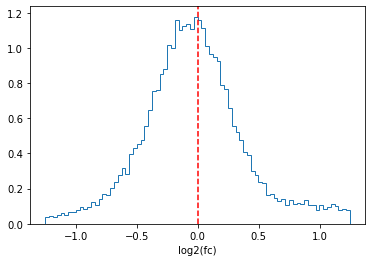

complete dataset


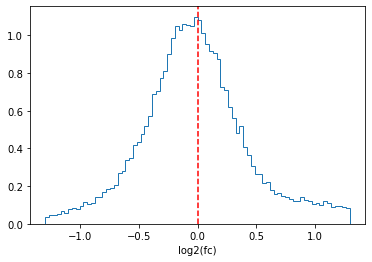

median -0.042780887625696096, mode -0.01188197490323506
using median for shift
shift cond 2 by 0.042780887625696096


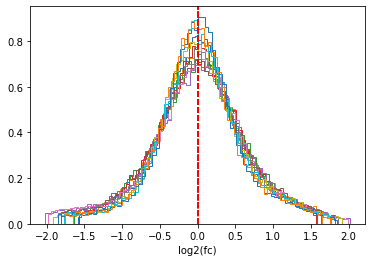

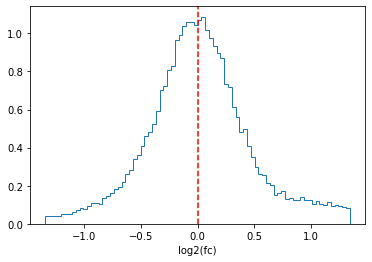

normalized between conditions
t_ion2nonan_sw 0.09473776817321777
t_intensity_selection 3.4354538917541504
t_ion2nonan_sw 0.09295105934143066
t_intensity_selection 3.815092086791992
checked 0 of 37860 ions
checked 2000 of 37860 ions
checked 4000 of 37860 ions
checked 6000 of 37860 ions
checked 8000 of 37860 ions
checked 10000 of 37860 ions
checked 12000 of 37860 ions
checked 14000 of 37860 ions
checked 16000 of 37860 ions
checked 18000 of 37860 ions
checked 20000 of 37860 ions
checked 22000 of 37860 ions
checked 24000 of 37860 ions
checked 26000 of 37860 ions
checked 28000 of 37860 ions
checked 30000 of 37860 ions
checked 32000 of 37860 ions
checked 34000 of 37860 ions
checked 36000 of 37860 ions
checked 0 of 6162 prots
checked 100 of 6162 prots
checked 200 of 6162 prots
checked 300 of 6162 prots
checked 400 of 6162 prots
checked 500 of 6162 prots
checked 600 of 6162 prots
checked 700 of 6162 prots
checked 800 of 6162 prots
checked 900 of 6162 prots
checked 1000 of 6162 prots
checked 11

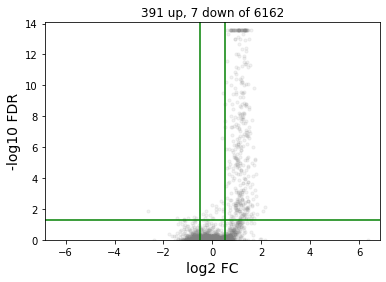

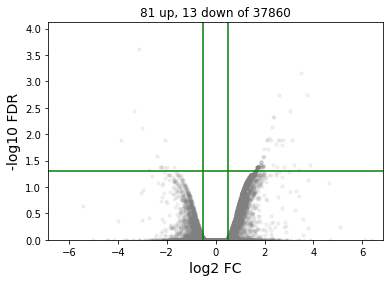

FileNotFoundError: [Errno 2] No such file or directory: './test_data/prot2organism.tsv'

In [ ]:
protein_df, peptide_df = benchmark_proteomics("./test_data/oconnel_set/peptides.txt", "./test_data/oconnel_set/samples.map.tsv", "./test_data/oconnel_set/prot2organism.tsv")
get_tps_fps(protein_df, "./test_data/oconnel_set/prot2organism.tsv", 0.05, 0.3)



df size before 6261
df size after 6166
condpair c1_VS_c2
total TPs 624
total FPs 5542
regulated 382
false positives 2
true positives 380
regulated control 382
precision 0.005235602094240838
precision 0.005235602094240838


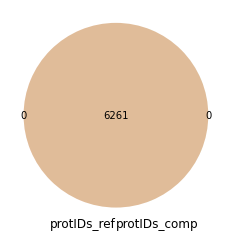

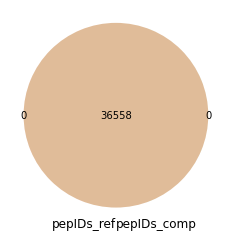

in ref only {'P40495', 'P09457', 'Q04178', 'Q06103'}
in AP only {'P32377', 'REV__Q8WZ42'}


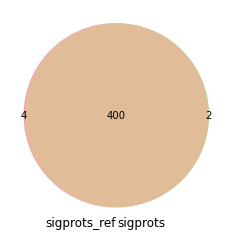

,protein_x,peptide,peptide_pval_ref,peptide_fc_ref,protein_y,peptide_pval,peptide_fc,peptide_pval_diff
12568,P13188,LVPGIFADVK,3.923550e-05,1.692764,P13188,0.000161,1.692764,4.092430
34967,P49755,LEDLSESIVNDFAYMK,5.117636e-07,-5.431690,P49755,0.000002,-5.431690,3.743216
17413,P39517,TAAFVIPTLEK,4.532842e-04,1.745022,P39517,0.001241,1.745022,2.738525
17922,P04840,VSDSGIVTLAYK,5.970053e-05,1.679757,P04840,0.000154,1.679757,2.572536
19003,P21954,TFESEAAHGTVTR,1.373624e-04,1.544291,P21954,0.000351,1.544291,2.554308
18623,P10664,VGYTLPSHIISTSDVTR,5.187443e-05,1.542295,P10664,0.000125,1.542295,2.412225
8911,Q8WTT2,FYLENLEQMVK,5.890546e-04,-2.116749,Q8WTT2,0.001391,-2.116749,2.362012
24966,P0CX83,LAASVVGVGK,6.947782e-05,1.496234,P0CX83,0.000160,1.496234,2.303878
7070,P53252,SAAGAFGPELSR,3.197514e-04,1.416255,P53252,0.000728,1.416255,2.277405
7888,P15108,LLDAPAAIR,1.598168e-04,1.394997,P15108,0.000352,1.394997,2.201609


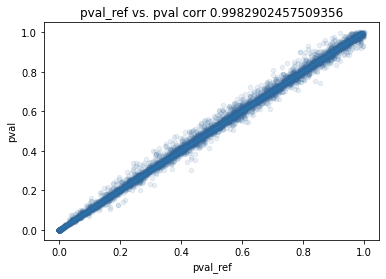

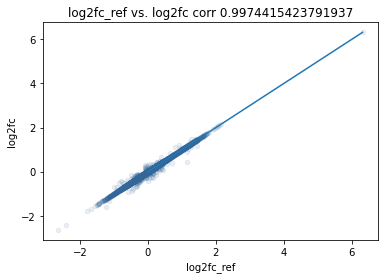

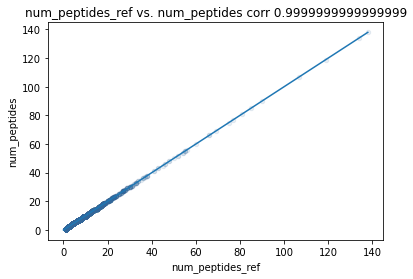

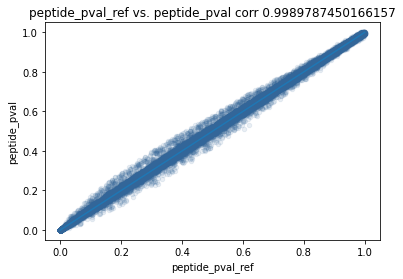

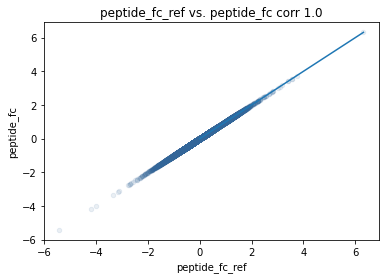

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,protein,pval_ref,log2fc_ref,condpair,fdr,pval,log2fc,num_peptides,pseudoint1,pseudoint2,num_peptides_ref,pvaldiff
4785,Q07478,0.000000e+00,1.463486,c1_VS_c2,2.673502e-14,2.220446e-16,1.463486,6,9.816131e+12,3.559484e+12,6,inf
4999,P48589,0.000000e+00,1.202589,c1_VS_c2,5.055350e-14,4.440892e-16,1.202589,5,4.827367e+13,2.097467e+13,5,inf
831,P09436,0.000000e+00,0.586271,c1_VS_c2,2.673502e-14,2.220446e-16,0.586271,22,1.495750e+13,9.962628e+12,22,inf
1269,P41277,0.000000e+00,0.898029,c1_VS_c2,5.055350e-14,4.440892e-16,0.898029,9,4.919142e+13,2.639706e+13,9,inf
3129,P04840,0.000000e+00,0.934643,c1_VS_c2,2.673502e-14,2.220446e-16,0.934643,10,2.222228e+13,1.162607e+13,10,inf
4527,P38625,0.000000e+00,1.251770,c1_VS_c2,2.673502e-14,2.220446e-16,1.251770,10,1.497156e+13,6.287046e+12,10,inf
2176,P0CX38,0.000000e+00,0.893923,c1_VS_c2,9.755939e-14,8.881784e-16,0.893923,9,5.217662e+13,2.807877e+13,9,inf
2161,P0CX24,0.000000e+00,1.083787,c1_VS_c2,2.673502e-14,2.220446e-16,1.083787,8,5.778701e+13,2.726327e+13,8,inf
366,P00950,0.000000e+00,1.024225,c1_VS_c2,5.055350e-14,4.440892e-16,1.024225,10,2.430966e+14,1.195244e+14,10,inf
4906,P04147,1.265654e-12,1.193845,c1_VS_c2,3.040765e-10,4.419576e-12,1.193845,16,3.346367e+13,1.462819e+13,16,1.804025


,protein_x,peptide,peptide_pval_ref,peptide_fc_ref,protein_y,peptide_pval,peptide_fc,peptide_pval_diff
12568,P13188,LVPGIFADVK,3.923550e-05,1.692764,P13188,0.000161,1.692764,4.092430
34967,P49755,LEDLSESIVNDFAYMK,5.117636e-07,-5.431690,P49755,0.000002,-5.431690,3.743216
17413,P39517,TAAFVIPTLEK,4.532842e-04,1.745022,P39517,0.001241,1.745022,2.738525
17922,P04840,VSDSGIVTLAYK,5.970053e-05,1.679757,P04840,0.000154,1.679757,2.572536
19003,P21954,TFESEAAHGTVTR,1.373624e-04,1.544291,P21954,0.000351,1.544291,2.554308
...,...,...,...,...,...,...,...,...
10945,Q9H974,RPVGGFLLDGFQGNPTTLEAR,2.821214e-02,-1.652336,Q9H974,0.012422,-1.652336,0.440314
25664,Q9UQB8,ELGDVLFQMAEVHR,6.541096e-02,-1.855920,Q9UQB8,0.028763,-1.855920,0.439733
13958,P07246,IVGLSELPK,1.453537e-04,1.647577,P07246,0.000064,1.647577,0.438538
3475,P17967,PLFTELAK,9.304383e-05,1.719968,P17967,0.000037,1.719968,0.399515


,protein,pval_ref,log2fc_ref,condpair,fdr,pval,log2fc,num_peptides,pseudoint1,pseudoint2,num_peptides_ref,pvaldiff,numpep_diff
4785,Q07478,0.000000,1.463486,c1_VS_c2,2.673502e-14,2.220446e-16,1.463486,6,9.816131e+12,3.559484e+12,6,inf,0
1372,P42771,0.656239,-0.653255,c1_VS_c2,9.974131e-01,6.641084e-01,-0.653255,2,2.799715e+12,4.403147e+12,2,0.017197,0
763,CON__P34955,0.960461,0.104095,c1_VS_c2,9.977700e-01,9.492602e-01,0.104095,3,1.631158e+12,1.517610e+12,3,0.016924,0
2730,Q3LXA3,0.853100,-0.231899,c1_VS_c2,9.974131e-01,8.431246e-01,-0.231899,8,4.045126e+12,4.750512e+12,8,0.016969,0
1589,P35573,0.593300,-0.119356,c1_VS_c2,9.906184e-01,6.003205e-01,-0.119356,9,6.240376e+12,6.778608e+12,9,0.016971,0
575,Q7Z3B3,0.628123,0.144018,c1_VS_c2,9.935146e-01,6.355632e-01,0.144018,2,5.932546e+11,5.368926e+11,2,0.016988,0
243,Q9NXV2,0.713464,-0.148862,c1_VS_c2,9.974131e-01,7.219171e-01,-0.148862,1,4.192759e+11,4.648491e+11,1,0.016992,0
4298,Q4LE39,0.938764,0.119920,c1_VS_c2,9.974131e-01,9.277610e-01,0.119920,7,4.900530e+12,4.509657e+12,7,0.017009,0
2683,Q9BWT6,0.181497,-0.404664,c1_VS_c2,8.086011e-01,1.836497e-01,-0.404664,2,7.899683e+11,1.045745e+12,2,0.017011,0
5875,Q8N584,0.430542,-0.522461,c1_VS_c2,9.683714e-01,4.356552e-01,-0.522461,1,6.709919e+10,9.638151e+10,1,0.017033,0


In [ ]:
#hide
import pandas as pd
protein_df = pd.read_csv("./test_data/oconnel_set/AP_protein_out.tsv", sep = "\t")
peptide_df = pd.read_csv("./test_data/oconnel_set/AP_peptide_out.tsv", sep = "\t")
get_tps_fps(protein_df, "./test_data/oconnel_set/prot2organism.tsv", 0.05, 0.3)

compare_to_reference("./test_data/oconnel_set/detail_pepinfos.tsv", protein_df, peptide_df, "./test_data/oconnel_set/reference_c1_vs_c2.tsv","./test_data/oconnel_set/outdir/")

In [ ]:
#hide
# compare_to_reference(result_df, "./test_data/reference_c1_vs_c2.tsv", "c1_VS_c2")
# assigned_df = annotate_dataframe(result_df, "./test_data/prot2organism.tsv")


# ref_df = pd.read_csv("./test_data/reference_c1_vs_c2.tsv", sep = "\t")
# merged = pd.merge(result_df, ref_df, how='inner', on = "protein", suffixes=["", "_ref"])
# display(merged)
# merged["pval_diff"] = np.absolute(merged["pval"].to_numpy() - merged["pval_ref"])
# merged["fc_diff"] = np.absolute(merged["fc"] - merged["log2FC_ref"])
# merged = merged.sort_values(by=["pval_diff",'fc_diff'], ascending = False)
# display(merged)

In [ ]:
#export
import pandas as pd
import numpy as np
import uuid
import random

def test_run_pipeline():

    sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7', 'B8', 'B9','B10', 'B11', 'B12'],
    'condition' : ['A', 'A', 'A', 'B', 'B', 'B','B', 'B', 'B','B', 'B', 'B','B', 'B', 'B']})
    unnormed_df = generate_random_input(10000, sample2cond_df)
    res_df, pep_df = run_pipeline(unnormed_df, sample2cond_df, 2, False)
    plot_pvals(pep_df)

def generate_random_input(num_pep,sample2cond_df , simulate_nas = False):
    pepnames = generate_peptide_list(num_pep, [2, 3, 5, 3]) #gives uuid strings for each peptide
    print(len(pepnames))
    protnames = generate_protein_list(pepnames)
    nrep_1 = 3
    nrep_2 = 12
    randarrays1 = 10+ 1.5*np.random.randn(len(pepnames),nrep_1)
    randarrays2 = 10+ 3.5*np.random.randn(len(pepnames),nrep_2)

    if simulate_nas:
        idxs_1 = np.unique(np.random.randint(0, nrep_1, size= int(len(randarrays1)/3)))
        randarrays1[idxs_1] = np.nan
        idxs_2 = np.unique(np.random.randint(0, nrep_2, size= int(len(randarrays2)/3)))
        randarrays2[idxs_2] = np.nan

    randarrays = np.concatenate((randarrays1, randarrays2), axis = 1)
    df_intens = pd.DataFrame(randarrays, columns= sample2cond_df["sample"].tolist())
    df_intens.insert(1,"protein", protnames)
    df_intens.insert(0, "ion", pepnames )
    df_intens = df_intens.set_index("ion")
    return df_intens

def generate_peptide_list(num_peps, levels ):
    """levels is list of ints, each int inidcates, how many potential possibilities there are on this level"""
    pepcount = 0
    count = 0
    peptides = []
    while count < num_peps:
        list = [f'pep{pepcount}']

        for levelidx, level in enumerate(levels):
            num_events = np.random.randint(1,level)
            new_list = []
            for elem in list:
                for idx in range(num_events):
                    new_list.append(elem + f"_LVL{levelidx}_mod{idx}")
                    count+=1
            list = new_list
        peptides.extend(list)
        pepcount+=1

    return peptides



def generate_protein_list(pepnames):
    res = []
    assigned = 0
    protcount = 0
    while assigned < len(pepnames):
        protstring = f"P{protcount}"
        num_peps = random.randint(2,10)
        for i in range(num_peps):
            res.append(protstring)
        assigned+=num_peps
        protcount+=1
    res = res[:len(pepnames)]
    return res

# Utility functions to compare against other methods

In [ ]:
#export
def annotate_fcs_to_wideformat_table(wideformat_df, columns_intens_c1, columns_intens_c2, num_reps = None):
    wideformat_df[columns_intens_c1+columns_intens_c2] = wideformat_df[columns_intens_c1+columns_intens_c2].replace(0, np.nan)
    prots_c1 = wideformat_df[columns_intens_c1]
    prots_c2 = wideformat_df[columns_intens_c2]

    prots_c1 = prots_c1.dropna(thresh = num_reps) #if None then no nans, i.e. all replicates
    prots_c2 = prots_c2.dropna(thresh = num_reps)
    both_idx = prots_c1.index.intersection(prots_c2.index)
    wideformat_df["median_int_c1"] = prots_c1.loc[both_idx].median(axis = 1, skipna = True)
    wideformat_df["median_int_c2"] = prots_c2.loc[both_idx].median(axis = 1, skipna = True)
    wideformat_df["median_intensity"] = (wideformat_df["median_int_c1"] + wideformat_df["median_int_c2"])/2
    wideformat_df = wideformat_df.loc[both_idx]
    wideformat_df[f"log2fc"] = np.log2(wideformat_df[f"median_int_c1"]) - np.log2(wideformat_df[f"median_int_c2"])
    return wideformat_df

In [ ]:
#export
def prepare_mq_table(mq_df, columns_intens_c1, columns_intens_c2):
    mq_df = mq_df[mq_df["Species"]!= np.nan]
    mq_df = mq_df[mq_df['Reverse']!= "+"]
    mq_df = mq_df[mq_df['Potential contaminant'] != "+"]
    mq_df = mq_df.rename(columns = {'Species' : "PG.Organisms", 'Protein IDs' : 'protein'})
    mq_df[columns_intens_c1+columns_intens_c2] = mq_df[columns_intens_c1+columns_intens_c2].replace(0, np.nan)
    prots_c1 = mq_df[columns_intens_c1]
    prots_c2 = mq_df[columns_intens_c2]

    prots_c1 = prots_c1.dropna(thresh = 2)
    prots_c2 = prots_c2.dropna(thresh = 2)
    both_idx = prots_c1.index.intersection(prots_c2.index)

    mq_df["median_int_c1"] = prots_c1.loc[both_idx].median(axis = 1, skipna = True)
    mq_df["median_int_c2"] = prots_c2.loc[both_idx].median(axis = 1, skipna = True)
    mq_df = mq_df.loc[both_idx]
    mq_df[f"log2fc"] = np.log2(mq_df[f"median_int_c1"]) - np.log2(mq_df[f"median_int_c2"])
    mq_df["method"] = ["MaxQuant" for x in range(len(mq_df.index))]
    return mq_df

# System-wide benchmark

In [ ]:
#export

def cluster_selected_proteins(protnames, quant_df, normed_c1, normed_c2, pval_threshold_basis = 0.05, fcfc_threshold = 0, take_median_ion=False):
    pep2prot = dict(zip(quant_df.index, quant_df['protein']))
    ions_to_check = normed_c1.ion2nonNanvals.keys() & normed_c2.ion2nonNanvals.keys()
    deedpair2doublediffdist = {}
    bgpair2diffDist = {}
    p2z = {}
    prot2diffions = {}
    root_node = anytree.Node('parent')
    for ion in ions_to_check:
        protein = pep2prot.get(ion)
        if protein not in protnames:
            continue
        vals1 = normed_c1.ion2nonNanvals.get(ion)
        vals2 = normed_c2.ion2nonNanvals.get(ion)
        diffDist = aqbg.get_subtracted_bg(bgpair2diffDist,normed_c1, normed_c2,ion, p2z)

        diffIon = aqdiff.DifferentialIon(vals1, vals2, diffDist, ion,outlier_correction=False)

        
        prot_ions = prot2diffions.get(protein, list())
        prot_ions.append(diffIon)
        prot2diffions[protein] = prot_ions
    
    for prot in prot2diffions.keys():
        ions = prot2diffions.get(prot)
        clustered_root_node = aqclust.get_scored_clusterselected_ions(prot, ions, normed_c1, normed_c2, bgpair2diffDist, p2z, deedpair2doublediffdist, pval_threshold_basis = pval_threshold_basis, fcfc_threshold = fcfc_threshold, take_median_ion=take_median_ion)
        clustered_root_node.parent = root_node
    
    return root_node

import alphaquant.normalization as aqnorm
def create_background_dists_from_prepared_files(samplemap_file, quant_file, cond1, cond2):

    quant_df = pd.read_csv(quant_file, sep = "\t",index_col='ion')
    samplemap_df = aqutils.load_samplemap(samplemap_file)

    df_c1, df_c2, c1_samples, c2_samples = get_c1_c2_dfs(quant_df, samplemap_df, [cond1, cond2])

    df_c1, df_c2 = aqnorm.get_normalized_dfs(df_c1, df_c2, c1_samples, c2_samples, minrep= min(len(df_c1.columns), len(df_c2.columns)), runtime_plots = False)#filter for no missing values
    p2z = {}
    normed_c1 = aqbg.ConditionBackgrounds(df_c1, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2, p2z)
    return quant_df, normed_c1, normed_c2


def get_c1_c2_dfs(unnormed_df, labelmap_df, condpair, minrep = 2):
    c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
    c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
    df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
    df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)

    return df_c1, df_c2, c1_samples, c2_samples
    

In [ ]:
#export
import alphaquant.diff_analysis_manager as aqmgr
import alphaquant.normalization as aqnorm
import alphaquant.cluster_ions as aqclust
import alphaquant.diffquant_utils as aqutils
import anytree
import math
import os
import alphaquant.diff_analysis_manager as aqdiffmgr
import alphaquant.background_distributions as aqbg
import pandas as pd


def load_real_example_ions(input_file, samplemap_file, num_ions = 20):
    p2z = {}
    samplemap_df = aqutils.load_samplemap(samplemap_file)
    fragion_df = pd.read_csv(input_file, sep = "\t")
    _, samplemap_df = aqutils.prepare_loaded_tables(fragion_df, samplemap_df)
    fragion_df = fragion_df.set_index('ion')

    c1_samples, c2_samples, df_c1, df_c2 = aqdiffmgr.format_condpair_input(samplemap_df, fragion_df, ('S1', 'S2'), minrep= 4)
    df_c1_normed, df_c2_normed = aqnorm.get_normalized_dfs(df_c1, df_c2, c1_samples, c2_samples, minrep=4, runtime_plots = False)
    normed_c1 = aqbg.ConditionBackgrounds(df_c1_normed, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2_normed, p2z)
    diffions = get_subset_of_diffions(normed_c1, normed_c2, num_ions)
    return diffions, normed_c1, normed_c2


def get_filtered_protnodes(condpair, results_dir_unfiltered):
    condpairtree = aqutils.read_condpair_tree(condpair[0], condpair[1], results_dir_unfiltered)
    protnodes = condpairtree.children
    selected_protnodes = []
    for protnode in protnodes:
        filtered_protnode = filter_check_protnode(protnode)
        if filtered_protnode == None:
            continue
        if (filtered_protnode.fc >0.2) or (filtered_protnode.p_val < 0.05) :
            continue
        selected_protnodes.append(filtered_protnode)
    
    return selected_protnodes



def filter_check_protnode(protnode):

    # filter the base nodes, prepare the ms1 and fragion nodes
    for base_node in protnode.leaves:
        if base_node.cluster != 0:
            base_node.parent = None
    frgion_ms1_nodes = anytree.search.findall(protnode, filter_=lambda node:  (node.type == 'frgion') or (node.type == 'ms1_isotopes'))

    check_nodes = set()
    #annotate if fragion_ms1 has enough leafs
    for frg_ms1_node in frgion_ms1_nodes:
        if len(frg_ms1_node.leaves) <3:
            frg_ms1_node.parent = None
        else:
            check_nodes.add(frg_ms1_node)


    type2required_children = {"mod_seq_charge":2, "mod_seq":2, "seq":1, "gene":3}
    nodetypes = ["mod_seq_charge", "mod_seq", "seq", "gene"]

    for nodetype in nodetypes:
        check_nodes =  anytree.search.findall(protnode, filter_=lambda node:  node.type == nodetype) #for each level, check if there are enough children
        for check_node in check_nodes:
            num_children = len([x for x in check_node.children if (x.cluster ==0)])
            if (num_children<type2required_children.get(check_node.type)) or (check_node.fc > 0.1):
                check_node.parent = None
                if nodetype == "gene":
                    return None
            else:
                check_node.has_enough = True
    if len(check_nodes)==0:
        return None
    else:
        return list(check_nodes)[0]


import alphaquant.diff_analysis as aqdiff

def get_subset_of_diffions(normed_c1, normed_c2, num_ions):
    ion2diffDist = {}
    p2z = {}
    diffions = []
    ions_to_check = normed_c1.ion2nonNanvals.keys() & normed_c2.ion2nonNanvals.keys()
    count_ions = 0
    for idx, ion in enumerate(ions_to_check):
        if count_ions==num_ions:
            break
        vals1 = normed_c1.ion2nonNanvals.get(ion)
        vals2 = normed_c2.ion2nonNanvals.get(ion)
        diffDist = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion, p2z)
        diffIon = aqdiff.DifferentialIon(vals1, vals2, diffDist, ion, outlier_correction = False)
        diffions.append(diffIon)
        count_ions+=1
    
    return diffions



def add_perturbations_to_proteins(protnodes):
    #go through each protein and randomly add perturbations at different levels, if a perturbation is added, propagate it to the children etc.
    for protnode in protnodes:
        for level_nodes in anytree.LevelOrderGroupIter(protnode, filter_= lambda x : 'gene' not in x.type): #iterate through all levels below protein
            for nodes_of_interest in group_level_nodes_by_parents(level_nodes):
                perturb = np.random.uniform(0, 1) < 0.3 #randomly select ~30% of the samples for perturbation
                num_perturb = math.ceil(len(nodes_of_interest)*0.2) if len(nodes_of_interest)>2 else 0
                perturb_idxs = random.sample(list(range(len(nodes_of_interest))), num_perturb)
                for sub_idx in range(len(nodes_of_interest)):
                    node_of_interest = nodes_of_interest[sub_idx]
                    applied_shift_parent = 0 if not hasattr(node_of_interest.parent, 'applied_shift') else node_of_interest.parent.applied_shift #check if the parent of the node already had a shift applied, if yes, add this shift
                    node_of_interest.applied_shift = applied_shift_parent
                    node_of_interest.applied_shift_local = 0
                    if (sub_idx in perturb_idxs) and perturb:
                        applied_shift = np.random.uniform(-2, 2)
                        node_of_interest.applied_shift += applied_shift
                        node_of_interest.applied_shift_local = applied_shift


def group_level_nodes_by_parents(nodes_of_interest):
    parent2nodes = {}
    for node in nodes_of_interest:
        parent2nodes[node.parent] = parent2nodes.get(node.parent, []) + [node]
    return list(parent2nodes.values())

def get_filtered_intensity_df(fragion_df, protnodes):    

    ions_included = []
    for protnode in protnodes:
        ions_included.extend([x.name  for x in protnode.leaves if x.type == 'base'])
    
    #drop the unincluded ions
    fragion_df = fragion_df.loc[ions_included]

    return fragion_df


def get_perturbed_intensity_df(fragion_df, samplemap, protnodes):    
    
    ion2shift = {}
    for protnode in protnodes:
        ion2shift.update({x.name : x.applied_shift for x in protnode.leaves if x.type =='base'})
    #drop the unincluded ions
    fragion_df = fragion_df.loc[list(ion2shift.keys())]

    #determine the factors to be added
    shifts_up = np.array([np.array([abs(ion2shift.get(x)) if ion2shift.get(x)> 0 else 0 for x in fragion_df.index])])
    shifts_down = np.array([np.array([abs(ion2shift.get(x)) if ion2shift.get(x)< 0 else 0 for x in fragion_df.index])])

    s1_samples = list(samplemap[samplemap["condition"]=="S1"]["sample"])
    s2_samples = list(samplemap[samplemap["condition"]=="S2"]["sample"])

    fragion_df[s1_samples] =fragion_df[s1_samples] +shifts_up.T
    fragion_df[s2_samples] =fragion_df[s2_samples]+shifts_down.T
    

    return fragion_df


def run_perturbation_test(input_file, samplemap, input_file_filtered = None, input_file_perturbed = None, run_diffanalysis_benchm_set = False, run_filtered = True,run_perturbed = True, run_perturbed_no_iontree = True, cluster_threshold_pval_perturbed = 0.01, runtime_plots = True):
    condpair_combinations = [("S1", "S2")]
    results_dir = "results"
    results_dir_filtered = "results_filtered"
    results_dir_perturbed = "results_perturbed"
    results_dir_perturbed_unclustered = "results_perturbed_unclustered"
    fragion_df = aqutils.import_data(input_file)
    samplemap = aqutils.load_samplemap(samplemap)
    fragion_df, samplemap = aqutils.prepare_loaded_tables(fragion_df, samplemap)
    
    
    #run the diffanalysis of the basic dataset
    if run_diffanalysis_benchm_set:
        aqutils.store_method_parameters({'input_file': str(input_file)}, results_dir)
        aqmgr.run_pipeline(fragion_df, samplemap, condpair_combinations=condpair_combinations, minrep = 9, runtime_plots=runtime_plots, cluster_threshold_pval=0.05, cluster_threshold_fcfc=0,results_dir=results_dir)
    
    #filter the analyzed results for consistent, low-FC proteins
    if (not os.path.exists(f"{results_dir}/S1_filtered_VS_S2_filtered.iontrees.json")) or (input_file_filtered == None):
        protnodes_filt = get_filtered_protnodes(condpair_combinations[0], results_dir_unfiltered=results_dir)
        fragion_df_only_filt = get_filtered_intensity_df(fragion_df, protnodes_filt)
        aqclust.export_roots_to_json(protnodes_filt,("S1_filtered", "S2_filtered"), results_dir)
        fragion_df_only_filt.reset_index().to_csv("filtered_fragions.tsv", sep = "\t", index = None)
    else:
        protnodes_filt = aqutils.read_condpair_tree("S1_filtered", "S2_filtered", results_dir).children
        fragion_df_only_filt = pd.read_csv(input_file_filtered, sep = "\t",index_col='ion')
    
    #add perturbations to the filtered proteins
    if (not os.path.exists(f"{results_dir_perturbed}/S1_annot_VS_S2_annot.iontrees.json") or (input_file_perturbed == None)):
        add_perturbations_to_proteins(protnodes_filt)
        if not os.path.exists(results_dir_perturbed):
            os.makedirs(results_dir_perturbed)
        aqclust.export_roots_to_json(protnodes_filt,("S1_annot", "S2_annot"), results_dir_perturbed)
        fragion_df_perturbed = get_perturbed_intensity_df(fragion_df, samplemap, protnodes_filt)
        fragion_df_perturbed.reset_index().to_csv("perturbed_fragions.tsv", sep = "\t", index = None)
    else:
        protnodes_filt = aqutils.read_condpair_tree("S1_annot", "S2_annot", results_dir_perturbed).children
        fragion_df_perturbed = pd.read_csv(input_file_perturbed, sep = "\t",index_col='ion')
    
    if run_filtered:
        aqmgr.run_pipeline(fragion_df_only_filt, samplemap, condpair_combinations=condpair_combinations, minrep = 9, normalize=True, runtime_plots=runtime_plots, use_iontree_if_possible=False, results_dir= results_dir_filtered)
    
    if run_perturbed_no_iontree:
        aqmgr.run_pipeline(fragion_df_perturbed, samplemap, condpair_combinations=condpair_combinations, minrep = 9,  normalize=True, runtime_plots=runtime_plots,use_iontree_if_possible=False,results_dir=results_dir_perturbed_unclustered)
    
    if run_perturbed:
        aqmgr.run_pipeline(fragion_df_perturbed, samplemap, condpair_combinations=condpair_combinations, minrep = 9,  normalize=True, runtime_plots=runtime_plots, cluster_threshold_pval=cluster_threshold_pval_perturbed, cluster_threshold_fcfc=0,results_dir=results_dir_perturbed)




In [ ]:
#export
import alphaquant.visualizations as aqviz
import alphaquant.diffquant_utils as aqutils
import sklearn.metrics


def compare_cluster_to_benchmarks(results_dir_unperturbed, results_dir_perturbed, results_dir_perturbed_unclustered):
    aqviz.compare_fcs_unperturbed_vs_perturbed_and_clustered(results_dir_unperturbed,results_dir_perturbed, results_dir_perturbed_unclustered)


def evaluate_per_level(level2annotated_shift, level2classified_shift):
    for level in level2annotated_shift.keys():
        y_true = level2annotated_shift.get(level)
        y_pred = level2classified_shift.get(level)
        metrics = sklearn.metrics.precision_recall_fscore_support(y_true=y_true, y_pred=y_pred)
        accuracy = sklearn.metrics.accuracy_score(y_true=y_true, y_pred= y_pred)
        print(f"level {level}")
        print(f"accuracy:{accuracy}\tprecision:{metrics[0]}\trecall{metrics[1]}\tfscore{metrics[2]}")


def count_correctly_excluded(protnodes_annotated, protnodes_clustered):
    level2annotated_shift = {}
    level2classified_shift = {}
    name2node_annot = {x.name : x for x in protnodes_annotated}
    name2node_clustered = {x.name : x for x in protnodes_clustered}
    for name in name2node_annot.keys():
        protnode_annotated = name2node_annot.get(name)
        protnode_clustered = name2node_clustered.get(name)
        for annot_nodes in anytree.LevelOrderGroupIter(protnode_annotated, filter_= lambda x : 'gene' not in x.type):
            for annot_node in annot_nodes:
                clustered_node = anytree.find(protnode_clustered, filter_= lambda x : annot_node.name == x.name)
                annot_shifted = annot_node.applied_shift_local!=0
                cluster_nonzero = clustered_node.cluster != 0
                if (not annot_shifted) and (not cluster_nonzero):
                    continue
                level2annotated_shift[annot_node.type] = level2annotated_shift.get(annot_node.type, [])
                level2classified_shift[annot_node.type] = level2classified_shift.get(clustered_node.type, [])
                level2annotated_shift[annot_node.type].append(annot_shifted)
                level2classified_shift[annot_node.type].append(cluster_nonzero)
    evaluate_per_level(level2annotated_shift, level2classified_shift)


def eval_clustered_results(results_perturbed):
    protnodes_annot = aqutils.read_condpair_tree("S1_annot", "S2_annot", results_folder=results_perturbed).children
    protnodes_perturbed = aqutils.read_condpair_tree("S1", "S2", results_folder=results_perturbed).children
    count_correctly_excluded(protnodes_annot, protnodes_perturbed)





# Prepare Benchmarking Sets

In [ ]:
#export
from pyopenms import ProteaseDigestion, AASequence
import pyfasta
import pandas as pd


def read_and_filter_output_table_to_single_organism(input_table, fastas,desired_organism , software_filter_function = None):

    undesired_peptides = get_peptides_set(fastas)
    print("got undesired peptides")
    pd.DataFrame({"peptide" : list(undesired_peptides)}).to_csv(f"{input_table}.undesired_peptides.tsv", sep = "\t")
    print("start filtering")
    if software_filter_function == None:
        software_filter_function = decide_filter_function(input_table = input_table)
    tableit = pd.read_csv(input_table, sep = "\t", chunksize=1000_000)
    tables = []
    for table_df in tableit:
        table_df = software_filter_function(table_df, undesired_peptides, desired_organism)
        tables.append(table_df)

    yeast_df = pd.concat(tables, ignore_index = True)
    return yeast_df
    

def get_peptides_set(fastas):
    peps_merged = set()
    for fasta in fastas:
        # try:
        #     peps = set(pd.read_csv(f"{fasta}.all_peptides.tsv", sep = "\t")["peptide"])
        # except:
            #print("could not find digested version of the fasta, try to digest")
        peps = retrieve_all_peptides_from_fasta_and_save(fasta)
        peps_merged = peps_merged.union(peps)
    return peps_merged

def retrieve_all_peptides_from_fasta_and_save(fasta):

    digestor = ProteaseDigestion()
    digestor.setEnzyme('Trypsin/P')

    digestor.setMissedCleavages(2)

    f = pyfasta.Fasta(fasta)

    all_results = []
    for key in f.keys():
        protseq = str(f.get(key))
        peptides = get_peptides_from_protein_sequence(protseq=protseq, digestor=digestor)
        all_results.extend(peptides)
    
    df = pd.DataFrame({'peptide' : all_results})
    df.to_csv(f"{fasta}.all_peptides.tsv", index = None)
    return set(df["peptide"])


def get_peptides_from_protein_sequence(protseq, digestor):
    val = AASequence.fromString(protseq)
    peptides = []
    digestor.digest(val, peptides, 4, 60)
    for pep in peptides:
        hass_pref = pep.hasPrefix(pep)
        if not hass_pref:
            print(pep)
    peptides = [str(x) for x in peptides]
    if len(peptides)>0:
        n_terminal_peptide = peptides[0]
        m_removed_peptides = get_m_replaced_peps(peptides)
        peptides += m_removed_peptides #add the m-removed peptides
    return peptides


def get_m_replaced_peps(peptides):
    m_removed_peptides = []
    for peptide in peptides:
        m_removed_peptide = peptide[0].replace("M", "") + peptide[1:]
        m_removed_peptides.append(m_removed_peptide)
    return m_removed_peptides



def spectronaut_filtering(table_df, undesired_peptides, desired_organism):
    table_df = table_df[[(x not in undesired_peptides) for x in table_df['PEP.StrippedSequence']]]
    if desired_organism is not None:
        table_df = table_df[table_df["PG.Organisms"] == desired_organism]

    return table_df

def diann_filtering(table_df, undesired_peptides, desired_organism):
    table_df = table_df[[(x not in undesired_peptides) for x in table_df['Stripped.Sequence']]]
    if desired_organism is not None:
        table_df = table_df[[(desired_organism in x) for x in table_df['Protein.Names']]]
    return table_df


def decide_filter_function(input_table):
    columns_table = pd.read_csv(input_table, sep = "\t", nrows=2).columns
    if "PG.Organisms" in columns_table:
        software_filter_function = spectronaut_filtering
    elif 'Protein.Names' in columns_table:
        software_filter_function = diann_filtering
    else:
        raise Exception("file for filtering does not have the needed columns!")
    return software_filter_function
        

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [ ]:
#hide
def test_protein_digestion(seq, peptide):
    
    digestor = ProteaseDigestion()
    digestor.setEnzyme('Trypsin/P')

    digestor.setMissedCleavages(2)
    peptides = get_peptides_from_protein_sequence(seq, digestor)
    assert peptide in peptides

test_protein_digestion("MAKPCGVRLSGEARKQAEEFLYRFLPQKIIYLNQLLQEDSLNVADLTSLRAPLDIPIPDP", "AKPCGVR")

test_protein_digestion(seq = "MAADVSVTHRPPLSPKSGAEVEAGDAAERRAPEEELPPLDPEEIRKRLEHTERQFRNRRK", peptide = "AADVSVTHRPPLSPK")



# Spike-in Benchmarks

In [ ]:
#export
import alphaquant.diffquant_utils as aqutils
import seaborn as sns
import alphaquant.visualizations as aqplot
import os.path
import anytree
import copy
import numpy as np
    

def compare_aq_to_reference(protein_nodes, expected_log2fc, condpair, software_used, name, original_input_file, samplemap,quant_level_aq, quant_level_reference, tolerance_interval, xlim_lower, xlim_upper, savedir, predscore_cutoff, ml_exclude, percentile_to_retain, num_reps):
    
    fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))
    fig.suptitle(f"{software_used}, {aqutils.get_condpairname(condpair)}")
    nodes_precursors = generate_precursor_nodes_from_protein_nodes(protein_nodes, type=quant_level_aq)
    shift_to_expected_fc(nodes_precursors, expected_log2fc)
    
    #aqplot.plot_fc_dist_of_test_set(fcs = [x.fc for x in nodes_precursors], ax = ax[2][2])
    
    true_falses, predscores, reference_scores, fcs = aqplot.get_true_false_to_predscores(nodes_precursors, expected_log2fc)
    
    aqplot.plot_true_false_fcs_of_test_set(fcs=fcs, true_falses=true_falses, ax= ax[0][0])
    aqplot.plot_predictability_roc_curve(true_falses=true_falses, predscores=predscores, reference_scores=reference_scores, ax = ax[0][1], percentile_cutoff_indication=percentile_to_retain)
    aqplot.plot_predictability_precision_recall_curve(true_falses=true_falses, predscores=predscores, reference_scores=reference_scores, ax=ax[0][2], percentile_cutoff_indication=percentile_to_retain)

    
    if predscore_cutoff is not None:
        nodes_precursors = [x for x in nodes_precursors if abs(x.predscore)<predscore_cutoff]
    if (predscore_cutoff is None) and (ml_exclude):
        nodes_precursors = [x for x in nodes_precursors if not x.ml_excluded]


    
    original_df_reformat = get_original_input_df( c1 = condpair[0], c2 = condpair[1], input_file = original_input_file, samplemap_file = samplemap, input_type = quant_level_reference, num_reps = num_reps)
    node_df = get_node_df(nodes_precursors = nodes_precursors)

    
    if percentile_to_retain is not None:
        rough_tpr_cutoff = get_rough_tpr_cutoff(percentile_to_retain, true_falses)
        original_df_reformat, node_df = filter_top_qualityscore_percentiles(df_original=original_df_reformat, df_nodes=node_df, nodes_precursors=nodes_precursors, percentile=rough_tpr_cutoff, method=software_used)
        doublecheck_df_reformat = filter_score_from_original_df(original_input_file=original_input_file, input_type= quant_level_reference, c1 = condpair[0], c2 = condpair[1], samplemap_file=samplemap,percentile_to_use= rough_tpr_cutoff,minrep=num_reps)

    
    frac_outliers = aqutils.count_fraction_outliers_from_expected_fc(original_df_reformat, tolerance_interval, expected_log2fc)
    aqplot.plot_fc_intensity_scatter(original_df_reformat, f"{software_used} ({frac_outliers:.2f})", expected_log2fc = expected_log2fc, tolerance_interval = tolerance_interval, xlim_lower=xlim_lower, xlim_upper = xlim_upper, ax = ax[1][0])
    aqplot.plot_fc_intensity_scatter(doublecheck_df_reformat, f"{software_used} doublecheck", expected_log2fc = expected_log2fc, tolerance_interval = tolerance_interval, xlim_lower=xlim_lower, xlim_upper = xlim_upper, ax = ax[1][2])
    frac_outliers_aq = aqutils.count_fraction_outliers_from_expected_fc(node_df, tolerance_interval, expected_log2fc)
    aqplot.plot_fc_intensity_scatter(node_df, f"AlphaQuant ({frac_outliers_aq:.2f})", expected_log2fc = expected_log2fc, tolerance_interval = tolerance_interval, xlim_lower=xlim_lower, xlim_upper = xlim_upper, ax = ax[1][1])


    aqplot.plot_violin_plots_log2fcs([software_used, 'AlphaQuant'], [original_df_reformat, node_df], ax = ax[2][0])
    aqplot.plot_beeswarm_plot_log2fcs([software_used, 'AlphaQuant'], [original_df_reformat, node_df], ax = ax[2][1])

    aqplot.plot_outlier_fraction(node_df, reference_df = original_df_reformat, expected_log2fc=expected_log2fc, outlier_thresholds=[1.0, 0.5, 0.3], ax = ax[2][2])
    fig.tight_layout()
    plt.savefig(f"{savedir}/{name}_{software_used}.pdf")

    ax[0][0].figure.savefig(f"{savedir}/{name}_fc_dist.pdf")
    ax[0][1].figure.savefig(f"{savedir}/{name}_predictability_roc_curve.pdf")
    ax[0][2].figure.savefig(f"{savedir}/{name}_predictability_precision_recall_curve.pdf")
    ax[1][0].figure.savefig(f"{savedir}/{name}_{software_used}_fc_intensity_scatter.pdf")
    ax[1][1].figure.savefig(f"{savedir}/{name}_AlphaQuant_fc_intensity_scatter.pdf")
    ax[2][0].figure.savefig(f"{savedir}/{name}_violin_plot.pdf")
    ax[2][1].figure.savefig(f"{savedir}/{name}_beeswarm_plot.pdf")
    ax[2][1].figure.savefig(f"{savedir}/{name}_fraction_outliers.pdf")

    plt.show()




def shift_to_expected_fc(nodes_precursors, expected_log2fc):
    median_fc = np.median([x.fc for x in nodes_precursors])
    diff = expected_log2fc - median_fc
    for node in nodes_precursors:
        node.fc +=diff


def get_rough_tpr_cutoff(percentile_to_retain, true_false_vec):
    fraction_true = sum(true_false_vec)/len(true_false_vec)
    return fraction_true*percentile_to_retain



def get_top_percentile_node_df(nodes, percentile, node_filterfunction = None):
    
    if node_filterfunction is not None:
        nodes = [x for x in nodes if node_filterfunction(x)]
    nodes_sorted = sorted(nodes,key= lambda x : abs(x.predscore))
    nodes_sorted = nodes_sorted[:int(len(nodes_sorted)*percentile)]
    return get_node_df(nodes_sorted)


def filter_top_qualityscore_percentiles(df_original, df_nodes, nodes_precursors, percentile, method, node_filterfunction = None):
    top_precursors_aqscore, top_precursors_default_quality_score = get_top_percentile_peptides(nodes_precursors=nodes_precursors, percentile = percentile, method = method, node_filterfunction = node_filterfunction)
    df_original = df_original[[x in top_precursors_default_quality_score for x in df_original["ion"]]]
    df_nodes = df_nodes[[x in top_precursors_aqscore for x in df_nodes["ion"]]]
    
    return df_original, df_nodes
    


    
def get_top_percentile_peptides(nodes_precursors, percentile, method, node_filterfunction = None):
    if node_filterfunction is not None:
        nodes_precursors = [x for x in nodes_precursors if node_filterfunction(x)]
    nodes_aqscore_sorted = sorted(nodes_precursors, key = lambda x : abs(x.predscore))
    nodes_default_quality_score_sorted = sorted(nodes_precursors, key = lambda x : abs(x.default_quality_score), reverse=True) #the quality scores are higher is better, the predscore is lower is better

    #get the percentiles
    nodes_default_quality_score_sorted = nodes_default_quality_score_sorted[:int(percentile*len(nodes_default_quality_score_sorted))]
    nodes_aqscore_sorted = nodes_aqscore_sorted[:int(percentile*len(nodes_aqscore_sorted))]

    #get the precursor names
    if method == "Spectronaut":
        treename2simplename = convert_tree_ionname_to_simple_ionname_sn(nodes_precursors)
    if method =="DIANN":
        treename2simplename = convert_tree_ionname_to_simple_ionname_diann(nodes_precursors)

    precursors_default_quality_score = {treename2simplename.get(x.name) for x in nodes_default_quality_score_sorted}
    precursors_aqscore = {x.name for x in nodes_aqscore_sorted}
    return precursors_aqscore, precursors_default_quality_score

def compare_aq_w_method(nodes_precursors, c1, c2, spectronaut_file, samplemap_file, expected_log2fc = None, threshold = 0.5, input_type = "spectronaut_precursor", num_reps = None, method_name = "Spectronaut", tolerance_interval = 1, xlim_lower = -1, xlim_upper = 3.5):
    specnaut_reformat = get_original_input_df( c1 = c1, c2 = c2, input_file = spectronaut_file, samplemap_file = samplemap_file, input_type = input_type, num_reps = num_reps, expected_log2fc=expected_log2fc)
    node_df = get_node_df(nodes_precursors = nodes_precursors)
    aqutils.count_fraction_outliers_from_expected_fc(specnaut_reformat, threshold, expected_log2fc)
    aqplot.plot_fc_intensity_scatter(specnaut_reformat, method_name, expected_log2fc = expected_log2fc, tolerance_interval = tolerance_interval, xlim_lower=xlim_lower, xlim_upper = xlim_upper)
    aqutils.count_fraction_outliers_from_expected_fc(node_df, threshold, expected_log2fc)
    aqplot.plot_fc_intensity_scatter(node_df, "AlphaQuant", expected_log2fc = expected_log2fc)

def import_input_file_in_specified_format(input_file, input_type):
    print(f"use input type {input_type}")
    reformat_file = f"{input_file}.{input_type}.aq_reformat.tsv"
    if os.path.isfile(reformat_file):
        specnaut_reformat = pd.read_csv(reformat_file, sep = "\t", encoding ='latin1')
    else:
        specnaut_reformat = aqutils.import_data(input_file, input_type_to_use=input_type)
    return specnaut_reformat

def get_original_input_df(c1, c2, input_file, samplemap_file, num_reps, expected_log2fc  = None,input_type = "spectronaut_precursor"):
    specnaut_reformat = import_input_file_in_specified_format(input_file=input_file, input_type=input_type)
    samplemap_df = aqutils.load_samplemap(samplemap_file)
    c1_samples = list(samplemap_df[samplemap_df["condition"]==c1]["sample"])
    c2_samples = list(samplemap_df[samplemap_df["condition"]==c2]["sample"])
    specnaut_reformat = annotate_fcs_to_wideformat_table(specnaut_reformat,c1_samples, c2_samples, num_reps = num_reps)
    if expected_log2fc is not None:
        specnaut_reformat = correct_fcs_to_expected(specnaut_reformat, expected_log2fc)

    return specnaut_reformat

import numpy as np
def correct_fcs_to_expected(specnaut_reformat, expected_log2fc):
    log2fcs = specnaut_reformat["log2fc"]
    median_fc = np.median(log2fcs)
    diff = expected_log2fc-median_fc
    specnaut_reformat["log2fc"] = [x+diff for x in log2fcs]
    return specnaut_reformat


def get_node_df(nodes_precursors):
    node_info_dict = {'ion': [x.name for x in nodes_precursors], 'log2fc' : [x.fc for x in nodes_precursors], "median_intensity" : [x.min_intensity for x in nodes_precursors]}
    node_df = pd.DataFrame(node_info_dict)
    return node_df





def generate_precursor_nodes_from_protein_nodes(protein_nodes, shift_fc = None, type = "mod_seq_charge"):
    all_precursors = []
    for protein in protein_nodes:
        precursors = anytree.findall(protein, filter_= lambda x : (x.type == type))
        all_precursors.extend(precursors)
    all_precursors = [copy.copy(x) for x in all_precursors]
    if shift_fc is not None:
        for precursor in all_precursors:
            precursor.fc +=shift_fc
    return all_precursors

import re
def convert_tree_ionname_to_simple_ionname_sn(nodes):
    tree2simple = {}
    for node in nodes:
        groups = re.match("(.*MOD_)(.*)(_CHARGE_)(.*)(_.*)",node.name)
        tree2simple[node.name] = f"{groups[2]}.{groups[4]}"
    return tree2simple

def convert_tree_ionname_to_simple_ionname_diann(nodes):
    tree2simple = {}
    for node in nodes:
        groups = re.match("(.*MOD_)(.*)(_CHARGE_)(.*)(_.*)",node.name)
        tree2simple[node.name] = f"{groups[2]}{groups[4]}"
    return tree2simple



In [ ]:
#export

def filter_score_from_original_df(original_input_file, input_type, c1, c2, samplemap_file, percentile_to_use, minrep):
    _, config_dict, _ = aqutils.get_input_type_and_config_dict(input_file=original_input_file, input_type_to_use=input_type)

    sample_id = config_dict.get("sample_ID")
    precursor_id = config_dict.get("ion_cols")[0]
    

    #load samples
    samplemap = aqutils.load_samplemap(samplemap_file)
    samples_c1 = list(samplemap[[x ==c1 for x in samplemap["condition"]]]["sample"])
    samples_c2 = list(samplemap[[x ==c2 for x in samplemap["condition"]]]["sample"])

    #retrieve ions used by AlphaQuant
    aq_df = aqbench.import_input_file_in_specified_format(input_file = original_input_file, input_type= input_type)
    aq_df = aqutils.filter_df_to_minrep(aq_df, samples_c1, samples_c2, minrep)
    ions_used_aq = set(aq_df["ion"])

    samplemap = samplemap[[x == c1 or x == c2 for x in samplemap["condition"]]] #only the condition samples remain
    condition_samples = set(samplemap["sample"])
    reference_df_it = pd.read_csv(original_input_file, sep = "\t", chunksize= 100_000)
    reference_dfs = []
    for df_chunk in reference_df_it:
        df_chunk = df_chunk.drop_duplicates(subset = [sample_id, precursor_id])
        df_chunk = df_chunk[[x in ions_used_aq for x in df_chunk[precursor_id]]]
        df_chunk = df_chunk[[x in condition_samples for x in df_chunk[sample_id]]]
        reference_dfs.append(df_chunk)

    reference_df = pd.concat(reference_dfs, ignore_index=True)
    
    quality_id = aqutils.get_quality_score_column(reference_df)
    
    reference_df_filtered = filter_top_percentile_reference_df(reference_df, precursor_id, quality_id, percentile_to_use)
    filename = f"{original_input_file}_{aqutils.get_condpairname((c1, c2))}_scorefilt_{percentile_to_use :.2f}.tsv"
    reference_df_filtered.to_csv(filename, sep = "\t", index = None)
    reformated_df = read_reformat_filtered_df(filtered_file=filename, input_type_to_use=input_type, samplemap_file=samplemap_file, c1 = c1, c2 = c2, num_rep= minrep)
    
    return reformated_df


def filter_top_percentile_reference_df(reference_df, precursor_id, quality_id, percentile_to_use):
    groupedref = reference_df.groupby([precursor_id]).mean().reset_index()
    groupedref = groupedref.sort_values(by=quality_id, ascending=False)
    first_sample = list(groupedref[precursor_id][:3])

    cutoff_threshold = int(percentile_to_use * len(groupedref.index))
    best_ranked_ions = list(groupedref[precursor_id][:cutoff_threshold])

    assert (first_sample == best_ranked_ions[:3])

    filtered_df = reference_df[[x in best_ranked_ions for x in reference_df[precursor_id]]]

    return filtered_df


def read_reformat_filtered_df(filtered_file, input_type_to_use, samplemap_file, c1, c2, num_rep):
    samplemap_df = aqutils.load_samplemap(samplemap_file)
    input_df = aqutils.import_data(filtered_file, input_type_to_use=input_type_to_use)
    #input_df, samplemap_df = aqutils.prepare_loaded_tables(input_df, samplemap_df)

    c1_samples = list(samplemap_df[samplemap_df["condition"]==c1]["sample"])
    c2_samples = list(samplemap_df[samplemap_df["condition"]==c2]["sample"])
    annotated_df = aqbench.annotate_fcs_to_wideformat_table(input_df,c1_samples, c2_samples, num_reps = num_rep)
    return annotated_df


In [ ]:
#export
import alphaquant.benchmarking as aqbench
import alphaquant.visualizations as aqplot
import numpy as np
import alphaquant.classify_ions as aqclass
import alphaquant.diffquant_utils as aqutils
import alphaquant.cluster_ions as aqclust
import anytree

def load_tree_assign_predscores(c1, c2, samplemap,name,results_folder, re_run_assignment  = False, results_folder_diann = None, replace_nans = False, distort_precursor_modulo = np.inf):
    """retrieve the predictability scores from a previously run differential analysis. Re-run the predictability score analysis in case they are not available, or if specified"""
    s1, s2 = aqutils.get_samples_used_from_samplemap_file(samplemap, c1, c2)
    cpair_tree = aqutils.read_condpair_tree(c1, c2, results_folder=results_folder)
    cpair_tree.type = "asd"
    protnodes = anytree.findall(cpair_tree, filter_= lambda x : (x.type == "gene"),maxlevel=2)

    if hasattr(protnodes[0],'predscore') and not re_run_assignment:
        return protnodes

    aqclass.assign_predictability_scores(protnodes,results_folder,name = name, samples_used=s1+s2, precursor_cutoff=2, fc_cutoff=0, number_splits=2, plot_predictor_performance=True, replace_nans=replace_nans, distort_precursor_modulo = distort_precursor_modulo)
    if results_folder_diann is None:
        aqclust.update_nodes_w_ml_score(protnodes)
    return protnodes


def benchmark_configs_and_datasets(*,results_dir, expected_log2fcs,condpairs_to_check, original_input_file, samplemap_reference,  software_used, quant_levels_reference, quant_levels_aq = ['mod_seq_charge'], replace_nans = [True], distort_every_nth_precursor = [5, np.inf], 
predscore_cutoff = None, ml_exclude = False, percentile_to_retain = 0.7, num_reps = 9):
    """obtain """
    
    for idx_condpair in range(len(condpairs_to_check)):
        condpair = condpairs_to_check[idx_condpair]
        for replace_nan in replace_nans:

            for distort_modulo in distort_every_nth_precursor:
                name_analysis_level = get_benchmark_setting_name(condpair = condpair, replace_nan=replace_nan, distort_number=distort_modulo)
                protein_nodes = load_tree_assign_predscores(c1 = condpair[0], c2 = condpair[1], samplemap=samplemap_reference,name= name_analysis_level, results_folder = results_dir, replace_nans= replace_nan,distort_precursor_modulo = distort_modulo, re_run_assignment=True)
                for quant_idx in range(len(quant_levels_aq)):

                    quant_level_aq = quant_levels_aq[quant_idx]
                    quant_level_reference = quant_levels_reference[quant_idx]
                    name = name_analysis_level+quant_level_reference
                    print(f"TESTING: {name}")
                    
                    compare_aq_to_reference(protein_nodes, expected_log2fcs[idx_condpair], condpair=condpair, software_used=software_used, name = name, original_input_file=original_input_file, samplemap=samplemap_reference, quant_level_aq=quant_level_aq, quant_level_reference=quant_level_reference, 
                    tolerance_interval = 1, xlim_lower = -1, xlim_upper = 3.5,savedir = results_dir,predscore_cutoff = predscore_cutoff, ml_exclude = ml_exclude, percentile_to_retain=percentile_to_retain, num_reps = num_reps)

def intersect_with_diann(c1, c2, protnodes,results_folder, results_folder_diann):
    diann_intersect = aqclass.get_intersect_sn_diann_precursors(c1, c2, results_folder, results_folder_diann)
    for protein in protnodes:
        precursors = anytree.findall(protein, filter_= lambda x : (x.type == "mod_seq_charge"))
        for precursor in precursors:
            if precursor.name not in diann_intersect:
                precursor.parent = None


def get_benchmark_setting_name(condpair, replace_nan, distort_number, diann_intersect_dir = None):
    name = f"{condpair[0]}_{condpair[1]}_distort_every{distort_number}_"
    if replace_nan:
        name+="nanreplace_"
    if diann_intersect_dir:#in the case that e.g. Spectronaut results are overlayed with DIANN results
        if "no_mbr" in diann_intersect_dir:
            name+="diann_intersect_no_mbr"
        else:
            name+="diann_intersect_mbr"
    
    return name

## Classification tests

In [ ]:
#export
import pandas as pd
import functools

class ResultsTable():
    def __init__(self, input_file, input_name, fdr_threshold = 0.05):
        self._input_file = input_file
        self.input_name = input_name
        self.fdr_threshold = fdr_threshold
        self.protein_column = "protein"
        self.called_column = "called"
        self.species_column = "species"
        self.formated_dataframe = self.__reformat_input_file_to_default_dataframe()
    
    def get_proteins(self):
        return self.formated_dataframe[self.protein_column]

    def subset_to_relevant_columns(self):
        return self.formated_dataframe[[self.protein_column, self.called_column]]
    
    def __reformat_input_file_to_default_dataframe(self):
        return




class ResultsTableSpectronaut(ResultsTable):
    def __init__(self, input_file, input_name, fdr_threshold = 0.05):
        super().__init__(input_file=input_file, input_name=input_name, fdr_threshold=fdr_threshold)

        self.formated_dataframe = self.__reformat_input_file_to_default_dataframe()
        self.formated_dataframe = super().subset_to_relevant_columns()
        
    
    def __reformat_input_file_to_default_dataframe(self):
        results_df = self.__read_and_rename_input_file()
        results_df = self.__determine_called_proteins(results_df)
        return results_df

    def __read_and_rename_input_file(self):
        results_df = pd.read_excel(self._input_file, sheet_name=2)
        results_df = results_df.rename(mapper = {'Protein': self.protein_column}, axis=1)
        return results_df

    def __determine_called_proteins(self, results_df):
        results_df[self.called_column] = [x<self.fdr_threshold for x in results_df["adjusted.pvalue"]]
        return results_df


class ResultsTableAlphaQuant(ResultsTable):
    def __init__(self, input_file, input_name, fdr_threshold = 0.05):
        super().__init__(input_file=input_file, input_name=input_name, fdr_threshold=fdr_threshold)
        self.formated_dataframe = self.__reformat_input_file_to_default_dataframe()
        self.formated_dataframe = super().subset_to_relevant_columns()
    
    def __reformat_input_file_to_default_dataframe(self):
        results_df = self.__read_input_file()
        results_df = self.__determine_called_proteins(results_df)
        return results_df

    def __read_input_file(self):
        results_df = pd.read_csv(self._input_file, sep = "\t")
        return results_df

    def __determine_called_proteins(self, results_df):
        results_df[self.called_column] = [x<self.fdr_threshold for x in results_df["fdr"]]
        return results_df


import functools
class MergedResultsTable(ResultsTable):
    def __init__(self, list_of_results_tables):
        self._list_of_results_tables = list_of_results_tables
        self._list_of_result_dataframes = self.__get_list_of_result_dataframes()
        self.protein_column = self.__get_protein_column()
        self.called_column = self.__get_called_column()
        self.species_column = self.__get_species_column()
        self.fdr_threshold = self.__get_fdr_threshold()
        self._merge_column = self.protein_column
        self.formated_dataframe = self.merge_result_tables()
    
    def __get_protein_column(self):
        return self._list_of_results_tables[0].protein_column
    
    def __get_called_column(self):
        return self._list_of_results_tables[0].called_column

    def __get_species_column(self):
        return self._list_of_results_tables[0].species_column

    def __get_fdr_threshold(self):
        return self._list_of_results_tables[0].fdr_threshold
    
    def __get_list_of_result_dataframes(self):
        return [x.formated_dataframe for x in self._list_of_results_tables]
    
    def merge_result_tables(self):
        #self.__find_and_remove_redundant_columns()
        merged_table = self.__join_prepared_tables()
        merged_table = self.__replace_nans_with_false(merged_table)
        return merged_table

    def __join_prepared_tables(self):
        df_final = functools.reduce(lambda left,right: self.__specify_merge_params(left, right), self._list_of_results_tables)
        return df_final

    def __specify_merge_params(self, left_resultstable, right_resultstable):
        return pd.merge(left_resultstable.formated_dataframe, right_resultstable.formated_dataframe, on=self._merge_column, how = 'outer', suffixes= ("_"+left_resultstable.input_name, "_"+right_resultstable.input_name))

    
    @staticmethod
    def __replace_nans_with_false(merged_table):
        return merged_table.fillna(value=False)



In [ ]:
#export

class SpeciesAnnotator():
    def __init__(self, mapping_file, protein_column = 'PG.ProteinGroups', species_colum = 'PG.Organisms'):
        self._mapping_file = mapping_file
        self._protein_column = protein_column
        self._species_column = species_colum
        self._protein2species_dict = self.__init_protein2species_dict()

    def annotate_table_with_species(self, results_table):
        species_column = results_table.species_column
        protein_column = results_table.protein_column

        results_df = self.__add_organism_column(results_table.formated_dataframe, species_column, protein_column)
        results_df = self.__filter_non_matching_proteins(results_df, species_column)
        
        results_table.formated_dataframe = results_df
    
    def __add_organism_column(self, results_df,species_column, protein_column):
        results_df[species_column] = [self._protein2species_dict.get(x) for x in results_df[protein_column]]
        return results_df
    
    @staticmethod
    def __filter_non_matching_proteins(results_df, species_column):
        results_df = results_df[[x is not None for x in results_df[species_column]]]
        return results_df
    
    def __init_protein2species_dict(self):
        df = pd.read_csv(self._mapping_file, sep = "\t", usecols=[self._protein_column, self._species_column], encoding='latin1').drop_duplicates()
        df = self.__filter_double_mapping_species(df)
        protein2species = dict(zip(df[self._protein_column], df[self._species_column]))
        return protein2species
    
    def __filter_double_mapping_species(self, protein2species_df):
        protein2species_df = protein2species_df[[";" not in x for x in protein2species_df[self._species_column]]] #a semicolon seperates different species entries
        return protein2species_df


In [ ]:
#export
import seaborn as sns
import matplotlib.pyplot as plt

class ClassificationBenchmarker():
    def __init__(self, resultstable):
        self._resultstable = resultstable
        self._protein_column = resultstable.protein_column
        self._species_column = resultstable.species_column
        self.speciescount_table = self.__get_table_counting_detected_proteins_per_species()
        self.variable2falsecountthreshold = self.__calculate_acceptable_number_of_false_calls_per_variable()
    
    def plot_detected_proteins_per_species(self):
        ax = sns.barplot(data=self.speciescount_table, x = self._species_column, y = "value", hue="variable")
        self.__rotate_x_labels_of_barplot(ax)
        self.__annotate_plot_with_acceptable_false_id_numbers(ax)
        return ax

    def __annotate_plot_with_acceptable_false_id_numbers(self, ax):
        self.__annotate_plot_with_acceptable_false_id_for_given_variable("called_AlphaQuant", ax)
    
    def __annotate_plot_with_acceptable_false_id_for_given_variable(self, variable, ax):
        threshold = self.variable2falsecountthreshold.get(variable)
        ax.axhline(threshold)
    
   # def __get_color_of_variable()

    def __calculate_acceptable_number_of_false_calls_per_variable(self):
        variables = self.__get_variable_names()
        return self.__get_variable2threshold(variables)
    
    def __get_variable_names(self):
        return self.speciescount_table["variable"].drop_duplicates()

    def __get_variable2threshold(self, variables):
        variable2threshold = {}
        fdr = self._resultstable.fdr_threshold
        for variable in variables:
            called_proteins = self.__get_number_called_proteins_for_variable(variable)
            variable2threshold[variable] = self.__calculate_acceptable_protein_number(called_proteins, fdr)
        return variable2threshold

    def __get_number_called_proteins_for_variable(self, variable):
        subset_variables = self.speciescount_table.set_index("variable").loc[variable]
        num_proteins = sum(subset_variables["value"])
        return num_proteins

    def __test_get_number_called_proteins_for_variable(self):
        assert self.__get_number_called_proteins_for_variable("called_AlphaQuant") == 1448
        

    @staticmethod
    def __calculate_acceptable_protein_number(called_proteins, fdr):
        return int(called_proteins *fdr)

    @staticmethod
    def __rotate_x_labels_of_barplot(ax):
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

    def __get_table_counting_detected_proteins_per_species(self):
        df_melted = self._resultstable.formated_dataframe.melt(id_vars=[self._protein_column, self._species_column])
        df_grouped = df_melted.groupby([self._species_column, "variable"]).sum().reset_index()
        return df_grouped
    
    def run_tests(self):
        self.__test_get_number_called_proteins_for_variable()